# Plot observing schedule 
This code works with Python 3 and using the kapteyn package to plot the sky coverage of Apertif observations. The main plotting function is based on the plotting functionality of: https://github.com/eakadams/aperinfo


In [1]:
from astropy.coordinates import SkyCoord
import astropy.coordinates as coordinates
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy import units as u
import matplotlib.pyplot as plt
from kapteyn import maputils
from kapteyn.wcs import galactic, equatorial, fk4_no_e, fk5

import numpy as np
%matplotlib inline

In [2]:
# plotting code

def sky_plot_kapteyn(ra_array_lists,dec_array_lists,
                     color_list,label_list,figname,
                     survey_pointings = None,
                     mode = None,
                     obs = None,
                     sky = 'all',
                     schedule_pointings = None):
    """
    Make sky plots, using Kapteyn python package
    Inputs:
    ra_array_lists: list of RA arrays
    dec_array_lists: list of Dec array
    color_list: List of colors for plotting
    label_list: List of labels
    figname: output name for figure
    survey_pointings: File with survey pointings. If None, do nothing
    mode: 'beam' or 'obs' for plotting beams or whole observation. If None, default to obs
    obs: table w/ tid, ra, dec for obs to go with beams (for ref plotting). If None, do nothing
    sky: "all", "fall" or "spring"
    schedule_pointings: File with pointings for scheduling. If None, do nothing
    """
    #start the figure
    #first define a header
    dec0 = 89.9999999999   # Avoid plotting on the wrong side
    header = {'NAXIS'  :  2,
              'NAXIS1' :  40, 'NAXIS2': 40,
              'CTYPE1' : 'RA---ARC',
              'CRVAL1' :  0.0, 'CRPIX1' : 20, 'CUNIT1' : 'deg',
              'CDELT1' : -5.0, 'CTYPE2' : 'DEC--ARC',
              'CRVAL2' :  dec0, 'CRPIX2' : 20,
              'CUNIT2' : 'deg', 'CDELT2' : 5.0,
              }
    """    dec0 = 89.9999999999   # Avoid plotting on the wrong side
    header = {'NAXIS'  :  2,
              'NAXIS1' :  100, 'NAXIS2': 80,
              'CTYPE1' : 'RA---TAN',
              'CRVAL1' :  0.0, 'CRPIX1' : 50, 'CUNIT1' : 'deg',
              'CDELT1' : -5.0, 'CTYPE2' : 'DEC--TAN',
              'CRVAL2' :  dec0, 'CRPIX2' : 40,
              'CUNIT2' : 'deg', 'CDELT2' : 5.0,
              }
    header = {'NAXIS'  :  2,
              'NAXIS1' :  100, 'NAXIS2': 80,
              'CTYPE1' : 'RA---ARC',
              'CRVAL1' :  0.0, 'CRPIX1' : 50, 'CUNIT1' : 'deg',
              'CDELT1' : -5.0, 'CTYPE2' : 'DEC--ARC',
              'CRVAL2' :  dec0, 'CRPIX2' : 40,
              'CUNIT2' : 'deg', 'CDELT2' : 5.0,
              }
    """
  
    X = np.arange(0,360.0,15.0)
    Y = np.arange(0,90,15) #[20, 30,45, 60, 75]


    #figure instance
    fig = plt.figure(figsize=(12,12))
    frame = fig.add_axes((0.1,0.1,0.8,0.8))
    f = maputils.FITSimage(externalheader=header)

    lon_world = np.arange(0,360,30)
    lat_world = np.arange(0,90,15) #[20, 30, 60, 90]
    lon_constval = None
    lat_constval = 20
    
    if sky == 'spring':
        f.set_limits(pxlim=(17,28),pylim=(22,32))
        X = np.arange(120,270,15.0)
        Y = np.arange(0,90,15.)
        lat_constval = None
        lon_world = None #np.arange(120,270,60)
        lat_constval = None

    if sky == 'fall':
        f.set_limits(pxlim=(12,25.5),pylim=(8,14))
        X = np.arange(-90,180,15.0)
        Y = np.arange(0,90,15.)
        lat_constval = None
        lon_world = None #np.arange(-120,240,60)
        lat_constval = None
        
    annim = f.Annotatedimage(frame)
    grat = annim.Graticule(axnum=(1,2),wylim=(0.0,90.0), wxlim=(0,360),
                       startx=X, starty=Y)
    #grat = annim.Graticule(wylim=(0.0,90.0), wxlim=(0,360),
    #                       startx=X, starty=Y)
    grat.setp_gratline(color='0.75')
    
    grat.setp_lineswcs1(20, color='g', linestyle='--')

    # Plot labels inside the plot
    lon_kwargs = {'color':'k', 'fontsize':18}
    lat_kwargs = {'color':'k', 'fontsize':18}
    grat.Insidelabels(wcsaxis=0,
                      world=lon_world, constval=lat_constval,
                      fmt="Hms",
                      **lon_kwargs)
    #grat.Insidelabels(wcsaxis=1,
                      #world=lat_world, constval=lon_constval,
                     # fmt="Dms",
                     # **lat_kwargs)

    if mode is None:
        print("'mode' is not set, defaulting to observations")
        mode = 'obs'

    #set markersize
    if mode == 'obs' and sky == 'all':
        ms = 8
    if mode == 'beam' and sky == 'all':
        ms = 0.7
    if mode == 'beam' and sky == 'spring':
        ms = 5
    if mode == 'beam' and sky == 'fall':
        ms = 5
        
    #iterate through arrays and add to plot
    for ra,dec,cname,labname in zip(ra_array_lists,
                                    dec_array_lists,color_list,label_list):

        #check that list has length and only add in that csase
        if len(ra) >0:
            #get pixel coordinates:
            xp,yp=annim.topixel(ra,dec)
            annim.Marker(x=xp,y=yp,
                         marker='o',mode='pixel',markersize=ms, color='k', fillstyle='none')
            annim.Marker(x=xp,y=yp,
                         marker='o',mode='pixel',markersize=ms, color=cname,
                         label = labname, alpha=0.3)

    

    #add survey  pointings
    if survey_pointings is not None:
        sra, sdec = get_survey_ra_dec(survey_pointings)
        xs,ys = annim.topixel(sra,sdec)
        #check if doing schedulable also; assume this is linked
        #affects how I will plot
        if schedule_pointings is None:
            annim.Marker(x=xs,y=ys,
                         marker='o',mode='pixel',markersize=8,
                         color='black',fillstyle='none')
        else:
            ora, odec = get_schedule_ra_dec(schedule_pointings)
            xo, yo = annim.topixel(ora,odec)
            annim.Marker(x=xs,y=ys,
                         marker='o',mode='pixel',markersize=8,
                         color='gray',fillstyle='none',alpha=0.8)
            annim.Marker(x=xo,y=yo,
                         marker='o',mode='pixel',markersize=8,
                         color='black',fillstyle='none')
    

    #add all obs beams for context
    if mode == 'beam' and obs is not None:
        bra = np.empty(0)
        bdec = np.empty(0)
        #iterate through each obs and make array of full beams
        for tid,ra,dec in obs['taskID','field_ra','field_dec']:
            beams = np.arange(40)
            tids = np.full(40,tid)
            task = np.full(1,tid)
            raref = np.full(1,ra)
            decref = np.full(1,dec)
            #ras = np.full(40,ra)
            #decs = np.full(40,dec)
            ra,dec = get_ra_dec(tids,beams,task,raref,decref,cb_pos)
            bra =np.append(bra,ra)
            bdec = np.append(bdec,dec)

        if sky == 'all':
            msc = 1.1
            mewc = 0.1
        if sky == 'spring':
            msc = 5
            mewc = 0.5
        if sky == 'fall':
            msc = 5
            mewc = 0.5
        xb,yb = annim.topixel(bra,bdec)
        annim.Marker(x=xb,y=yb,marker='o',mode='pixel',markersize=msc,
                     mec='k',fillstyle='none',mew=mewc, alpha=0.5)
    
    #make figure
    annim.plot()
    #add legend
    plt.legend(fontsize=18)
    #save fig
    plt.savefig('{}.png'.format(figname))
    plt.show()
    plt.close()

In [3]:
# read in data from files to plot

survey=Table.read('ancillary_data/apertif_v12.21aug19.txt',format='ascii.fixed_width')
survey_coord=SkyCoord(survey['hmsdms'][(survey['label'] == 's') | (survey['label'] == 'm') | (survey['label'] == 'l')])
mds_coord=SkyCoord(survey['hmsdms'][(survey['label'] == 'm') | (survey['label'] == 'r') ])
second_coord=SkyCoord(survey['hmsdms'][(survey['label'] == 'l')])

sched=Table.read('ancillary_data/all_sched.csv')
sched_coord=SkyCoord(ra=sched['ra'],dec=sched['dec'],unit=[u.hour,u.deg])
sched = Table.read('/Users/adams/projects/aperinfo/files/obsatdb.csv')
sched_coord = SkyCoord(ra = sched['field_ra'], dec = sched['field_dec'], unit = u.deg)

sched_now=Table.read('imaging_220224.csv')
sched_coord_now=SkyCoord(ra=sched_now['ra'],dec=sched_now['dec'],unit=[u.hour,u.deg])


In [4]:
# calculate position of the Sun

start_time = Time('2022-02-21T08:00:00')
end_time = Time('2022-02-24T22:00:00')

obs_length = (end_time - start_time).to(u.h).value
timespan = start_time + np.linspace(0, obs_length, 10)*u.hour

Sun = coordinates.get_sun(timespan)

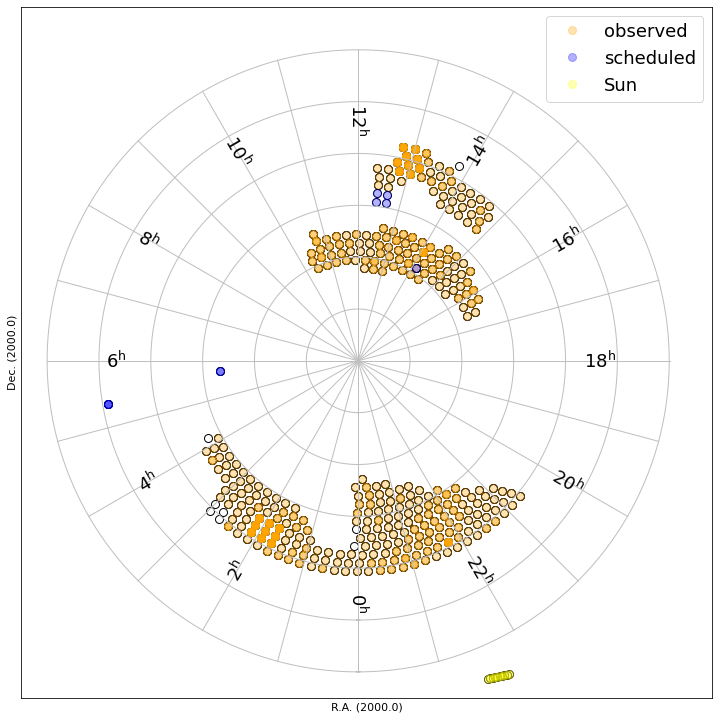

In [5]:
# make the plot
sky_plot_kapteyn([survey_coord.ra.deg, sched_coord.ra.deg, sched_coord_now.ra.deg, Sun.ra.deg],[survey_coord.dec.deg, sched_coord.dec.deg, sched_coord_now.dec.deg, Sun.dec.deg],
                     ['none','orange', 'b', 'yellow'],['','observed', 'scheduled', 'Sun'],'imaging_210901',
                     survey_pointings = None,
                     mode = 'obs',
                     obs = None,
                     sky = 'all',
                     schedule_pointings = None)